In [1]:
import codecs
import glob
import gzip
from datetime import datetime
import dateparser
from multiprocessing import Pool

import string 
import xmltodict
import gensim
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence

import spacy
nlp = spacy.load('en')
from operator import itemgetter

In [ ]:
%%time



In [4]:
%%time

line_delim = '\\new'

dataset = 'all'
# dataset = 'karbala'

with open('../data/stopwords', encoding='utf-8') as fp:
    stopwords = fp.read().split('\n')
    
exclude = ["’s", "'s", "-PRON-", "'''", "``", "–", "‘a", "--", "..."]
stopwords.extend(exclude)
stopwords.extend(list(string.punctuation))
# print(stopwords)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 442 µs


In [7]:
%%time

# Time Window Bin

def xml_to_tuple(path):
    
    path = path + '*.xml'
    doc_list = []
    print (u'Start parsing %s' % path)
    for fname in glob.glob(path):

        with codecs.open(fname, encoding='utf_8') as doc_file:

            try:
                doc = xmltodict.parse(doc_file.read())

                doc_list.append(
                    [doc['Document']['Id'],
                    str(dateparser.parse(doc['Document']['PublicationDateTime'])),
                    doc['Document']['Text'].replace('\r', line_delim).replace('\n', line_delim)]
                )

            except Exception as e: 
                pass
            
    print (u'%s , number of docs {:,} '.format(len(doc_list)) % path)

    return doc_list

def time_window_bin(file_list, txt_filepath):

#     print(file_list)
        
    pool = Pool(processes=7)              # start 7 worker processes
    doc_text = pool.map(xml_to_tuple, file_list)

    doc_text = [val for sublist in doc_text for val in sublist] # flatten the list
    doc_text = sorted(doc_text, key=itemgetter(1)) # sort by date
    
    dates = [x[1] for x in doc_text]

    print("Oldest doc from: " + dates[0]) # min
    print("Latest doc from: " + dates[-1]) # max
       
    date_month = dateparser.parse(dates[0])
    print(date_month)
    temp = []
    
    for doc in doc_text:
        if (dateparser.parse(doc[1]).month == date_month.month):
            temp.append(doc)
        else:
            doc_txt_file = gzip.open(txt_filepath % date_month.strftime('%Y_%m'), 'w') 
            print("writing %s to file" % date_month.strftime('%Y_%m')) 
            write_bin(doc_txt_file, temp)
            temp = []
            temp.append(doc)            
            date_month = dateparser.parse(doc[1])

    # write the rest of the temp     
    doc_txt_file = gzip.open(txt_filepath % date_month.strftime('%Y_%m'), 'w') 
    write_bin(doc_txt_file, temp)
    print ("number of documents parsed: {}".format(len(doc_text)) )
    
def write_bin(doc_txt_file, doc_text, limit_window=200000):
    
    if (len (doc_text) > limit_window): # special case to normalize the dataset 
        doc_text = doc_text[::2]
        doc_text = doc_text[::2]
    
    doc_txt_file.write( '\n'.join( ['\t'.join(doc) for doc in doc_text] ).encode("utf-8") )
    print('number of documents {} writing to: '.format(len(doc_text)) )
    doc_txt_file.close()
    


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


In [8]:
%%time


review_txt_filepath = 'data/windowbin/slices/total_windows_%s.gz'
path1 = '/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/*/English/*/'
path2 = '/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/*/*/English/'
# path1 = '/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Karbala/'
file_list = glob.glob(path1)
file_list.extend(glob.glob(path2))
file_list.sort()
# print(file_list)

time_window_bin(file_list, review_txt_filepath)

Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Kirkuk/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Erbil/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Diyala/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Iraq-Baghdad-Gulfwar/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Babel/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Al Muthanna/*.xml
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Basra/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Al Muthanna/*.xml , number of docs 9,927 
Start parsing /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Anbar/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Babel/*.xml , num

Iterate over the docs in the review_txt_all.txt we created before

Segment the reviews into individual sentences

Remove punctuation and excess whitespace

Lemmatize the text

In [5]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space or (len(token.orth_) < 2)

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with gzip.open(filename, 'rb') as f:
        for review in f:
            yield review.decode().replace(line_delim, '\n')
            
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=7):

        for sent in parsed_review.sents:
            yield (u' '.join([token.lemma_ for token in sent if not punct_space(token)]))

In [10]:
%%time

# dataset = 'karbala'
dataset = 'all'

unigram_sentences_filepath = 'data/windowbin/ngram/unigram_sentences_%s.gz' 
bigram_model_filepath = 'data/windowbin/ngram/bigram_model_%s' % dataset
bigram_sentences_filepath = 'data/windowbin/ngram/bigram_sentences_%s.txt' % dataset

# Ngram document/line 
final_doc_filepath = 'data/windowbin/bigram_transformed_reviews_%s.gz' % dataset


# Document doesn't matter anymore, this is collection level sentences
def text_unigram(review_txt_filepath, unigram_sentences_filepath):
    print("Start modeling unigrams " + datetime.now().strftime("%H:%M:%S"))
    
    f = gzip.open(unigram_sentences_filepath, 'w')
    
    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence.encode("utf-8") +'\n'.encode("utf-8"))
            
    f.close()
    print("finished modeling unigrams " + datetime.now().strftime("%H:%M:%S"))
    


def text_bigram(unigram_sentences_filepath):
    
    print ("starting modeling bigrams " + datetime.now().strftime("%H:%M:%S") + unigram_sentences_filepath)
    unigram_sentences = LineSentence(unigram_sentences_filepath)

    bigram_model = gensim.models.Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    # load the finished model from disk
    # bigram_model = Phraser.load(bigram_model_filepath)
    
    # Write collection sentences    
    f = gzip.open(bigram_sentences_filepath, 'w')
    
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence.encode("utf-8") + '\n'.encode("utf-8"))
        
    print ("finished modeling bigrams " + datetime.now().strftime("%H:%M:%S"))
    f.close()
    return bigram_model


def text_ngram_token(review_txt_filepath, final_doc_filepath):
    
#     unigram_filepath = unigram_sentences_filepath % dataset
#     text_unigram(review_txt_filepath, unigram_filepath) # Turn on/off
#     bigram_model = text_bigram(unigram_filepath) # Turn on/off    
    
    # load the finished model from disk
    bigram_model = gensim.models.Phrases.load('../data/eos/ngram/bigram_model_%s' % dataset)
    
    doc_num = 0
    doc_id = ''
    doc_date = ''
    doc_list = []
    
    print ("Starting modeling ngrams " + datetime.now().strftime("%H:%M:%S"))

    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                  batch_size=10000, n_threads=7):

        doc_id = parsed_review.text.split('\t')[0]
#         doc_date = parsed_review.text.split('\t')[1]

        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in nlp(parsed_review.text.split('\t')[2])
                          if not punct_space(token)]

        if (len(unigram_review) < 5 or len(unigram_review) > 3000):
            continue

        # apply the first-order phrase models
        ngram_doc = bigram_model[unigram_review]

        # remove any remaining stopwords and exclude list
        ngram_doc = [term for term in ngram_doc
                          if term not in stopwords]

        # write the transformed review as a line in the new file
        doc_list.append(doc_id + '\t' + u' '.join(ngram_doc))
    
    
    f = gzip.open(final_doc_filepath, 'w')         
    f.write( '\n'.join( doc_list ).encode("utf-8") )
    f.close()
    print ("finished modeling ngrams, {} documents processed ".format(len(doc_list)) + datetime.now().strftime("%H:%M:%S"))
    
   

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


In [11]:
%%time

#final output - tokenized text document/line 
bin_location = "data/windowbin/slices/total_windows_*.gz"
bin_text_path =  "data/windowbin/slices/text_%s"
file_list = glob.glob(bin_location)

print(file_list)

for fname in file_list:
    text_ngram_token(fname, bin_text_path % fname.split('/')[-1])

['data/windowbin/slices/total_windows_2014_08.gz', 'data/windowbin/slices/total_windows_2015_05.gz', 'data/windowbin/slices/total_windows_2015_01.gz', 'data/windowbin/slices/total_windows_2015_04.gz', 'data/windowbin/slices/total_windows_2014_05.gz', 'data/windowbin/slices/total_windows_2014_07.gz', 'data/windowbin/slices/total_windows_2014_02.gz', 'data/windowbin/slices/total_windows_2014_09.gz', 'data/windowbin/slices/total_windows_2014_03.gz', 'data/windowbin/slices/total_windows_2014_12.gz', 'data/windowbin/slices/total_windows_2014_06.gz', 'data/windowbin/slices/total_windows_2014_04.gz', 'data/windowbin/slices/total_windows_2015_06.gz', 'data/windowbin/slices/total_windows_2014_11.gz', 'data/windowbin/slices/total_windows_2015_03.gz', 'data/windowbin/slices/total_windows_2015_02.gz', 'data/windowbin/slices/total_windows_2014_10.gz']
Starting modeling ngrams 01:27:49


/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


finished modeling ngrams, 9058 documents processed 01:35:56
Starting modeling ngrams 01:36:06
finished modeling ngrams, 30208 documents processed 01:54:15
Starting modeling ngrams 01:54:26
finished modeling ngrams, 62 documents processed 01:54:29
Starting modeling ngrams 01:54:39
finished modeling ngrams, 35811 documents processed 02:18:27
Starting modeling ngrams 02:18:37
finished modeling ngrams, 27694 documents processed 02:33:03
Starting modeling ngrams 02:33:12
finished modeling ngrams, 4392 documents processed 02:35:50
Starting modeling ngrams 02:36:00
finished modeling ngrams, 16635 documents processed 02:43:04
Starting modeling ngrams 02:43:13
finished modeling ngrams, 14140 documents processed 02:53:08
Starting modeling ngrams 02:53:17
finished modeling ngrams, 19421 documents processed 03:01:44
Starting modeling ngrams 03:01:54
finished modeling ngrams, 93343 documents processed 03:56:03
Starting modeling ngrams 03:56:13
finished modeling ngrams, 21046 documents processed 04:

['data/windowbin/slices/total_windows_2014_02.gz', 'data/windowbin/slices/total_windows_2014_03.gz', 'data/windowbin/slices/total_windows_2014_04.gz', 'data/windowbin/slices/total_windows_2014_05.gz', 'data/windowbin/slices/total_windows_2014_06.gz', 'data/windowbin/slices/total_windows_2014_07.gz', 'data/windowbin/slices/total_windows_2014_08.gz', 'data/windowbin/slices/total_windows_2014_09.gz', 'data/windowbin/slices/total_windows_2014_10.gz', 'data/windowbin/slices/total_windows_2014_11.gz', 'data/windowbin/slices/total_windows_2014_12.gz', 'data/windowbin/slices/total_windows_2015_01.gz', 'data/windowbin/slices/total_windows_2015_02.gz', 'data/windowbin/slices/total_windows_2015_03.gz', 'data/windowbin/slices/total_windows_2015_04.gz', 'data/windowbin/slices/total_windows_2015_05.gz', 'data/windowbin/slices/total_windows_2015_06.gz']
['2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015

<IPython.core.display.Javascript object>


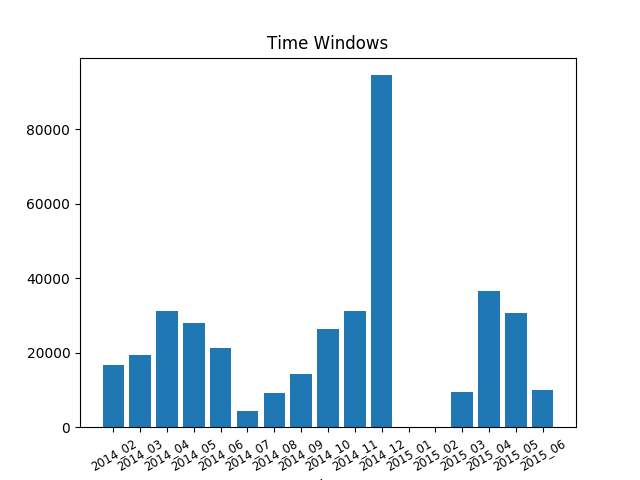

CPU times: user 10.4 s, sys: 404 ms, total: 10.8 s
Wall time: 10.6 s


In [3]:
%%time


from matplotlib import pyplot as plt
%matplotlib notebook

def corpus_info():
    
    corpus = []

    file_list = glob.glob('data/windowbin/slices/total_windows_*.gz')
    file_list.sort()
    print(file_list)
    

    for fname in file_list:
        num_lines = sum(1 for line in gzip.open(fname))
        corpus.append([fname[-10: -3], num_lines])
        
    x = [el[0] for el in corpus] # time window
    y = [el[1] for el in corpus] # number of docs
    
    print(x)
    print(y)
    print('total number of documents: %d' % sum(y))

    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, size='small')
    plt.title('Time Windows')
    plt.xlabel('Time')
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('../data/eos/graphs/windows_corpus_info.png', bbox_inches='tight', dpi=800)

corpus_info()